<a href="https://colab.research.google.com/github/Squirtle007/Noisy-Simulation-with-GPU-Acceleration/blob/main/%5BCirq%5DCross_Entropy_Benchmarking_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XEB with GPU Acceleration**

Based on the [tutorial](https://quantumai.google/cirq/noise/qcvv/xeb_theory).

Note that [**qsimcirq.QSimSimulator**](https://quantumai.google/reference/python/qsimcirq/QSimSimulator) is supported by **cuQuantum**, only **gpu_mode=1** needs to be specified in **qsim_options**:  
 `qsimcirq.QSimSimulator(qsim_options=qsimcirq.QSimOptions(gpu_mode=1)) `
(or click [here](https://quantumai.google/reference/python/qsimcirq/QSimOptions) to learn more details)

This tutorial uses **cirq.DensityMatrixSimulator** for noise simulation, please refer [here](https://quantumai.google/qsim/tutorials/noisy_qsimcirq) if using **qsimcirq.QSimSimulator**

In [1]:
# Download Miniconda installer
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!ls    #(List files in the current directory)
!chmod +x Miniconda3-latest-Linux-x86_64.sh    #(Make the Miniconda installer executable)


# Set python environment to default and install Miniconda
%env PYTHONPATH=
!./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# Add Miniconda to sys.path
import sys
sys.path.append("/usr/local/lib/python3.10/site-packages")

# Install conda and specify Python version
!conda install --channel defaults conda python=3.10 --yes

# Update all conda packages
!conda update --channel defaults --all --yes

# Install all necessary packages from conda-forge
!conda install -c conda-forge cuquantum==23.10.0.6 cuquantum-python==23.10.0 -y

--2024-04-15 08:32:10--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144041912 (137M) [application/octet-stream]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 137.37M   179MB/s    in 0.8s    

2024-04-15 08:32:11 (179 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [144041912/144041912]

Miniconda3-latest-Linux-x86_64.sh  sample_data
env: PYTHONPATH=
PREFIX=/usr/local
Unpacking payload ...
Exception ignored in: <module 'threading' from '/usr/local/install_tmp/_MEIrLfMjg/threading.pyc'>
Traceback (most recent call last):
  File "threading.py", line 1537, in _shutdown
  File "concurrent/futures/process.py", line 93, in _python_exit
  File "concurrent/futures/process.py

In [2]:
!conda install -c conda-forge cirq==1.3.0 -y

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cirq==1.3.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20230802.0      |       h6a678d5_2         1.4 MB
    aiohttp-3.9.3              |  py310h2372a71_1         677 KB  conda-forge
    aiosignal-1.3.1            |     pyhd8ed1ab_0          12 KB  conda-forge
    anyio-4.3.0                |     pyhd8ed1ab_0         100 KB  conda-forge
    async-timeout-4.0.3        |     pyhd8ed1ab_0          11 KB  conda-forge
    atomicwrites-1.4.1         |     pyhd8ed1ab_0          12 KB  conda-forge
    attrs-21.4.0               |     pyhd8ed1ab_0          49 KB  conda-forge
    backcall-0.2.0             |     pyh9f0ad1d_0          13 KB  conda-forge
    beautifulsoup4-4.12.3      | 

# Cross Entropy Benchmarking Theory

Cross entropy benchmarking uses the properties of random quantum programs to determine the fidelity of a wide variety of circuits. When applied to circuits with many qubits, XEB can characterize the performance of a large device. When applied to deep, two-qubit circuits it can be used to accurately characterize a two-qubit interaction potentially leading to better calibration.

In [3]:
# Standard imports
import cirq
import numpy as np

from cirq.contrib.svg import SVGCircuit

## The action of random circuits with noise
An XEB experiment collects data from the execution of random circuits
subject to noise. The effect of applying a random circuit with unitary $U$ is
modeled as $U$ followed by a depolarizing channel. The result is that the
initial state $|𝜓⟩$ is mapped to a density matrix $ρ_U$ as follows:

$$
    |𝜓⟩ → ρ_U = f |𝜓_U⟩⟨𝜓_U| + (1 - f) I / D
$$

where $|𝜓_U⟩ = U|𝜓⟩$, $D$ is the dimension of the Hilbert space, $I / D$ is the
maximally mixed state, and $f$ is the fidelity with which the circuit is
applied.

For this model to be accurate, we require $U$ to be a random circuit that scrambles errors. In practice, we use a particular circuit ansatz consisting of random single-qubit rotations interleaved with entangling gates.

### Possible single-qubit rotations
Geometrically, we choose 8 axes in the XY plane to perform a quarter-turn (pi/2 rotation) around. This is followed by a rotation around the Z axis of 8 different magnitudes.

These 8*8 possible rotations are chosen randomly when constructing the circuit.

In [4]:
exponents = np.linspace(0, 7/4, 8)
exponents

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

In [5]:
import itertools
SINGLE_QUBIT_GATES = [
    cirq.PhasedXZGate(x_exponent=0.5, z_exponent=z, axis_phase_exponent=a)
    for a, z in itertools.product(exponents, repeat=2)
]
SINGLE_QUBIT_GATES[:10], '...'

([cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.25),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.5),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=0.75),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.25),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.5),
  cirq.PhasedXZGate(axis_phase_exponent=0.0, x_exponent=0.5, z_exponent=1.75),
  cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=0.5, z_exponent=0.0),
  cirq.PhasedXZGate(axis_phase_exponent=0.25, x_exponent=0.5, z_exponent=0.25)],
 '...')

### Random circuit

We use `cirq.experiments.random_quantum_circuit_generation.random_rotations_between_two_qubit_circuit` to generate a random two-qubit circuit. Note that we provide the possible single-qubit rotations from above and declare that our two-qubit operation is the $\sqrt{i\mathrm{SWAP}}$ gate.

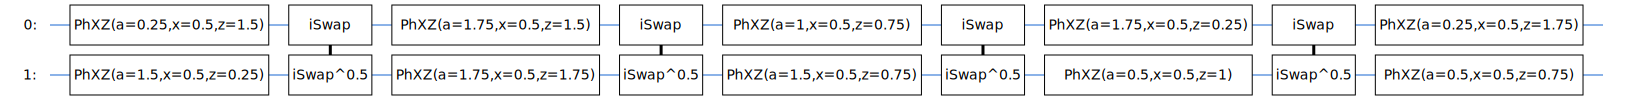

In [6]:
import cirq_google as cg
from cirq.experiments import random_quantum_circuit_generation as rqcg

q0, q1 = cirq.LineQubit.range(2)
circuit = rqcg.random_rotations_between_two_qubit_circuit(
    q0, q1,
    depth=4,
    two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b),
    single_qubit_gates=SINGLE_QUBIT_GATES
)
SVGCircuit(circuit)

## Estimating fidelity

Let $O_U$ be an observable that is diagonal in the computational
basis. Then the expectation value of $O_U$ on $ρ_U$ is given by

$$
    Tr(ρ_U O_U) = f ⟨𝜓_U|O_U|𝜓_U⟩ + (1 - f) Tr(O_U / D).
$$

This equation shows how $f$ can be estimated, since $Tr(ρ_U O_U)$ can be
estimated from experimental data, and $⟨𝜓_U|O_U|𝜓_U⟩$ and $Tr(O_U / D)$ can be
computed.

Let $e_U = ⟨𝜓_U|O_U|𝜓_U⟩$, $u_U = Tr(O_U / D)$, and $m_U$ denote the experimental
estimate of $Tr(ρ_U O_U)$. We can write the following linear equation (equivalent to the
expression above):

$$
    m_U = f e_U + (1-f) u_U \\
    m_U - u_U = f (e_U - u_U)
$$

In [7]:
# Make long circuits (which we will truncate)
MAX_DEPTH = 100
N_CIRCUITS = 10
circuits = [
    rqcg.random_rotations_between_two_qubit_circuit(
        q0, q1,
        depth=MAX_DEPTH,
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b),
        single_qubit_gates=SINGLE_QUBIT_GATES)
    for _ in range(N_CIRCUITS)
]

In [8]:
# We will truncate to these lengths
cycle_depths = np.arange(1, MAX_DEPTH + 1, 9)
cycle_depths

array([  1,  10,  19,  28,  37,  46,  55,  64,  73,  82,  91, 100])

### Execute circuits
Cross entropy benchmarking requires sampled bitstrings from the device being benchmarked *as well as* the true probabilities from a noiseless simulation. We find these quantities for all `(cycle_depth, circuit)` permutations.

In [9]:
!pip install qsimcirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 23.3 MB/s eta 0:00:00


In [10]:
import qsimcirq

# Set gpu_mode=1 to enable NVIDIA cuStateVec as backend!!!
pure_sim = qsimcirq.QSimSimulator(qsim_options=qsimcirq.QSimOptions(gpu_mode=1))


# Pauli Error. If there is an error, it is either X, Y, or Z
# with probability E_PAULI / 3
E_PAULI = 5e-3
noisy_sim = cirq.DensityMatrixSimulator(noise=cirq.depolarize(E_PAULI))

# These two qubit circuits have 2^2 = 4 probabilities
DIM = 4

records = []
for cycle_depth in cycle_depths:
    for circuit_i, circuit in enumerate(circuits):

        # Truncate the long circuit to the requested cycle_depth
        circuit_depth = cycle_depth * 2 + 1
        assert circuit_depth <= len(circuit)
        trunc_circuit = circuit[:circuit_depth]

        # Pure-state simulation
        psi = pure_sim.simulate(trunc_circuit).final_state_vector
        pure_probs = np.abs(psi)**2

        # Noisy execution
        meas_circuit = trunc_circuit + cirq.measure(q0, q1)
        sampled_inds = noisy_sim.sample(meas_circuit, repetitions=10_000).values[:,0]
        sampled_probs = np.bincount(sampled_inds, minlength=DIM) / len(sampled_inds)

        # Save the results
        records += [{
            'circuit_i': circuit_i,
            'cycle_depth': cycle_depth,
            'circuit_depth': circuit_depth,
            'pure_probs': pure_probs,
            'sampled_probs': sampled_probs,
        }]
        print('.', end='', flush=True)

........................................................................................................................

## What's the observable

What is $O_U$? Let's define it to be the observable that gives the sum of all probabilities, i.e.

$$
    O_U |x \rangle = p(x) |x \rangle
$$

for any bitstring $x$. We can use this to derive expressions for our quantities of interest.

$$
e_U = \langle \psi_U | O_U | \psi_U \rangle \\
   = \sum_x a_x^* \langle x | O_U | x \rangle a_x \\
   = \sum_x p(x) \langle x | O_U | x \rangle \\
   = \sum_x p(x) p(x)
$$

$e_U$ is simply the sum of squared ideal probabilities. $u_U$ is a normalizing factor that only depends on the operator. Since this operator has the true probabilities in the definition, they show up here anyways.

$$
u_U = \mathrm{Tr}[O_U / D] \\
    = 1/D \sum_x \langle x | O_U | x \rangle \\
    = 1/D \sum_x p(x)
$$

For the measured values, we use the definition of an expectation value
$$
\langle f(x) \rangle_\rho = \sum_x p(x) f(x)
$$
It becomes notationally confusing because remember: our operator on basis states returns the ideal probability of that basis state $p(x)$. The probability of observing a measured basis state is estimated from samples and denoted $p_\mathrm{est}(x)$ here.

$$
m_U = \mathrm{Tr}[\rho_U O_U] \\
    = \langle O_U \rangle_{\rho_U} = \sum_{x} p_\mathrm{est}(x) p(x)
$$

In [11]:
for record in records:
    e_u = np.sum(record['pure_probs']**2)
    u_u = np.sum(record['pure_probs']) / DIM
    m_u = np.sum(record['pure_probs'] * record['sampled_probs'])
    record.update(
        e_u=e_u,
        u_u=u_u,
        m_u=m_u,
    )

Remember:

$$
    m_U - u_U = f (e_U - u_U)
$$

We estimate f by performing least squares
minimization of the sum of squared residuals

$$
    \sum_U \left(f (e_U - u_U) - (m_U - u_U)\right)^2
$$

over different random circuits. The solution to the
least squares problem is given by

$$
    f = (∑_U (m_U - u_U) * (e_U - u_U)) / (∑_U (e_U - u_U)^2)
$$

In [12]:
import pandas as pd
df = pd.DataFrame(records)
df['y'] = df['m_u'] - df['u_u']
df['x'] = df['e_u'] - df['u_u']

df['numerator'] = df['x'] * df['y']
df['denominator'] = df['x'] ** 2
df.head()

,circuit_i,cycle_depth,circuit_depth,pure_probs,sampled_probs,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,3,"[0.56249994, 0.18749987, 0.18749997, 0.062499993]","[0.5494, 0.1954, 0.1927, 0.0625]",0.390625,0.25,0.385712,0.135712,0.140625,0.019085,0.019775
1,1,1,3,"[0.4633882, 0.2866116, 0.03661165, 0.21338831]","[0.455, 0.2884, 0.0439, 0.2127]",0.343750,0.25,0.340495,0.090495,0.093750,0.008484,0.008789
2,2,1,3,"[0.021446593, 0.72855324, 0.12499998, 0.12499993]","[0.0323, 0.7064, 0.1284, 0.1329]",0.562500,0.25,0.548005,0.298005,0.312500,0.093127,0.097656
3,3,1,3,"[0.13572325, 0.0107233, 0.36427665, 0.4892766]","[0.1418, 0.0187, 0.3584, 0.4811]",0.390625,0.25,0.385394,0.135394,0.140625,0.019040,0.019775
4,4,1,3,"[0.28661147, 0.21338834, 0.4633883, 0.036611628]","[0.2868, 0.2184, 0.4491, 0.0457]",0.343750,0.25,0.338585,0.088585,0.093750,0.008305,0.008789


### Fit

We'll plot the linear relationship and least-squares fit while we transform the raw DataFrame into one containing fidelities.

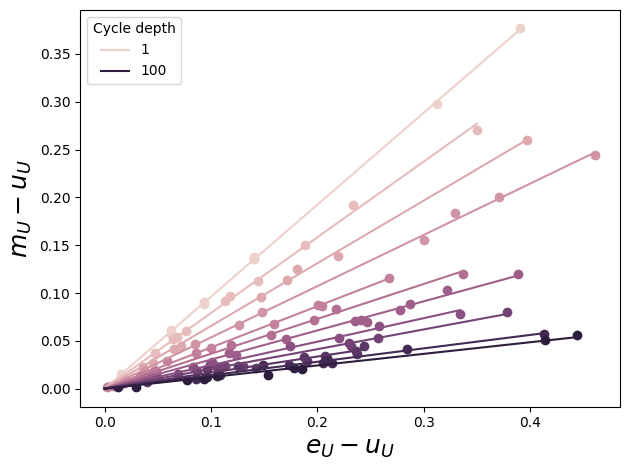

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns
colors = sns.cubehelix_palette(n_colors=len(cycle_depths))
colors = {k: colors[i] for i, k in enumerate(cycle_depths)}

_lines = []
def per_cycle_depth(df):
    fid_lsq = df['numerator'].sum() / df['denominator'].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df['x'].max())
    l, = plt.plot(xx, fid_lsq*xx, color=colors[cycle_depth])
    plt.scatter(df['x'], df['y'], color=colors[cycle_depth])

    global _lines
    _lines += [l] # for legend
    return pd.Series({'fidelity': fid_lsq})

fids = df.groupby('cycle_depth').apply(per_cycle_depth).reset_index()
plt.xlabel(r'$e_U - u_U$', fontsize=18)
plt.ylabel(r'$m_U - u_U$', fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0,-1]], cycle_depths[[0,-1]], loc='best', title='Cycle depth')
plt.tight_layout()

### Fidelities

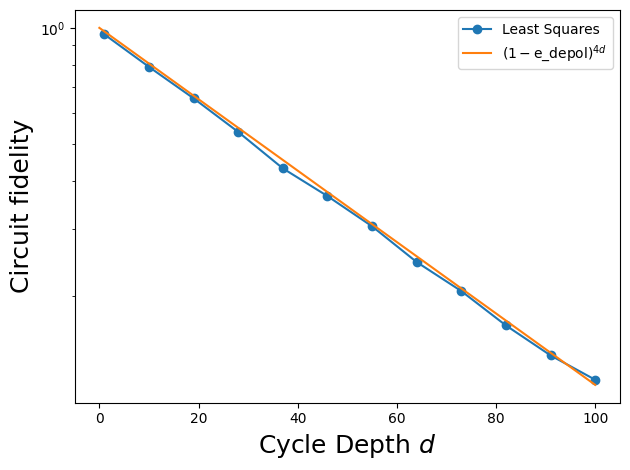

In [14]:
plt.plot(
    fids['cycle_depth'],
    fids['fidelity'],
    marker='o',
    label='Least Squares')

xx = np.linspace(0, fids['cycle_depth'].max())

# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
e_depol = E_PAULI / (1 - 1/DIM**2)

# The additional factor of four in the exponent is because each layer
# involves two moments of two qubits (so each layer has four applications
# of a single-qubit single-moment depolarizing channel).
plt.plot(xx, (1-e_depol)**(4*xx), label=r'$(1-\mathrm{e\_depol})^{4d}$')

plt.ylabel('Circuit fidelity', fontsize=18)
plt.xlabel('Cycle Depth $d$', fontsize=18)
plt.legend(loc='best')
plt.yscale('log')
plt.tight_layout()

In [15]:
from cirq.experiments.xeb_fitting import fit_exponential_decays

# Ordinarily, we'd use this function to fit curves for multiple pairs.
# We add our qubit pair as a column.
fids['pair'] = [(q0, q1)] * len(fids)

fit_df = fit_exponential_decays(fids)
fit_row = fit_df.iloc[0]
print(f"Noise model fidelity: {(1-e_depol)**4:.3e}")
print(f"XEB layer fidelity:   {fit_row['layer_fid']:.3e} +- {fit_row['layer_fid_std']:.2e}")

Noise model fidelity: 9.788e-01
XEB layer fidelity:   9.787e-01 +- 1.38e-04
